# Uncertainty 

This is a tutorial for the uncertainty module.

In [1]:
import copy
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures, Entity
from climada.hazard import Hazard
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5, ENT_DEMO_TODAY, ENT_DEMO_FUTURE

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

def exp_func(x_exp, exp_base=exp_base):
    exp = copy.deepcopy(exp_base)
    exp.value *= x_exp
    exp.check()
    return exp

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

2021-03-04 17:33:26,284 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-03-04 17:33:26,353 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


## Impact 

In [4]:
exp = exp_func
exp_distr = {"x_exp": sp.stats.beta(0.8, 1.2),
              }
exp_unc = UncVar(exp, exp_distr)

impf = impf_func
impf_distr = {
    "G": sp.stats.truncnorm(0.8,1.2),
    "v_half": sp.stats.uniform(35, 100),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 5)
    }
impf_unc = UncVar(impf, impf_distr)

haz = haz_base

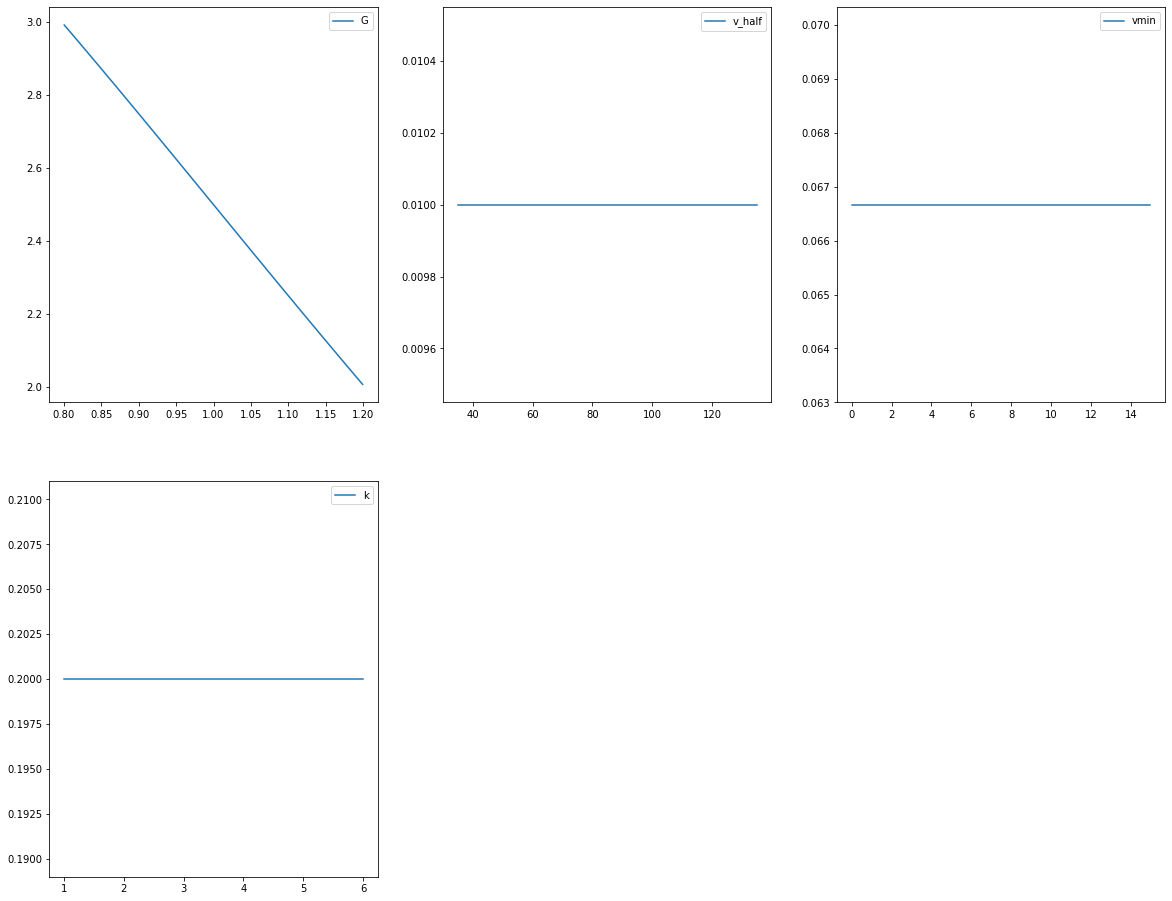

In [5]:
impf_unc.plot();

### Default methods 

In [6]:
unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=100, sampling_method='saltelli', sampling_kwargs = {'calc_second_order': False})

2021-03-04 17:31:38,929 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 700


,x_exp,G,v_half,vmin,k
0,0.125521,0.832731,86.855469,10.151367,2.401367
1,0.833040,0.832731,86.855469,10.151367,2.401367
2,0.125521,0.815430,86.855469,10.151367,2.401367
3,0.125521,0.832731,124.941406,10.151367,2.401367
4,0.125521,0.832731,86.855469,7.514648,2.401367
...,...,...,...,...,...
695,0.326540,0.853179,91.494141,1.560059,5.855957
696,0.326540,1.015208,41.396484,1.560059,5.855957
697,0.326540,1.015208,91.494141,11.037598,5.855957
698,0.326540,1.015208,91.494141,1.560059,4.239746


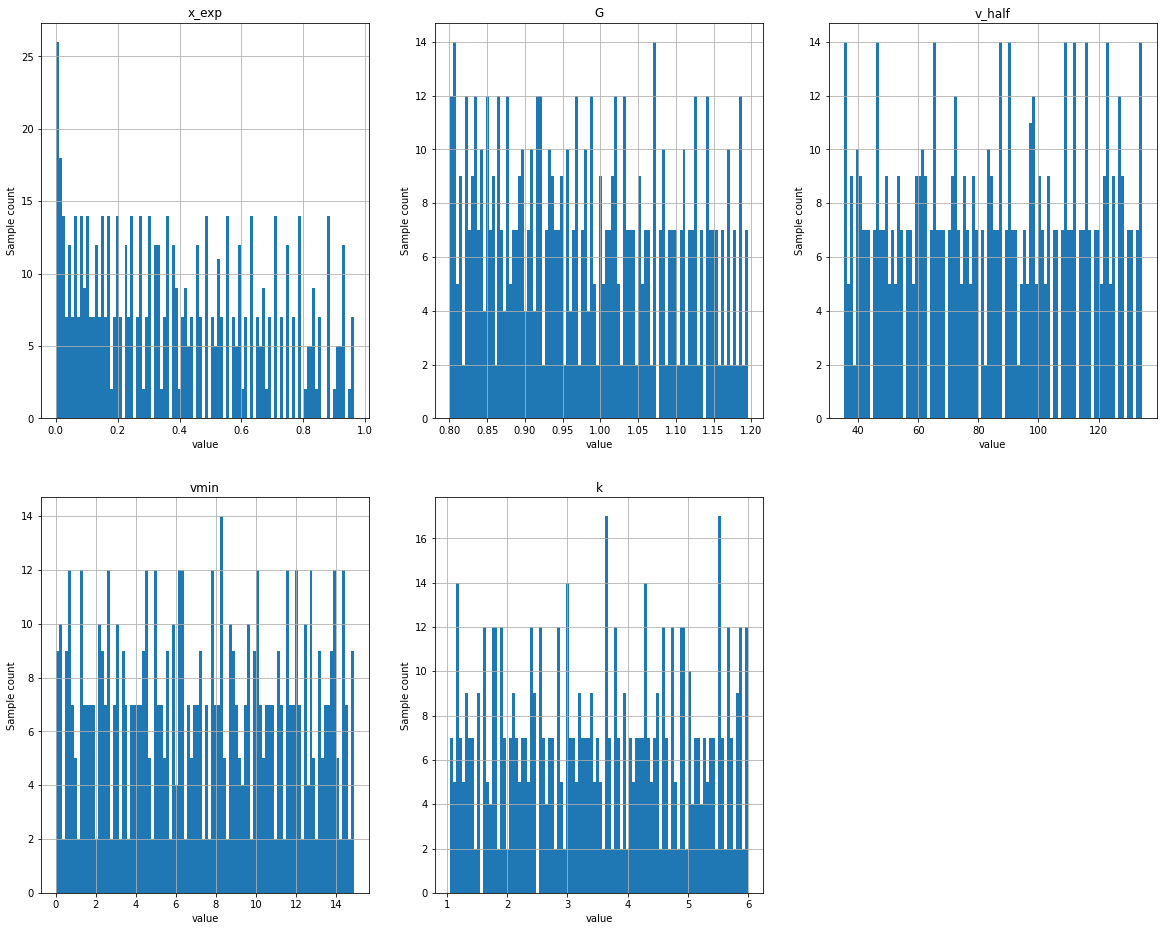

In [7]:
unc.plot_sample();

In [8]:
unc.calc_distribution(rp = [50, 100, 250])

2021-03-04 17:31:40,209 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 17:31:40,211 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-04 17:31:40,212 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:31:40,230 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:31:40,233 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 19.04s



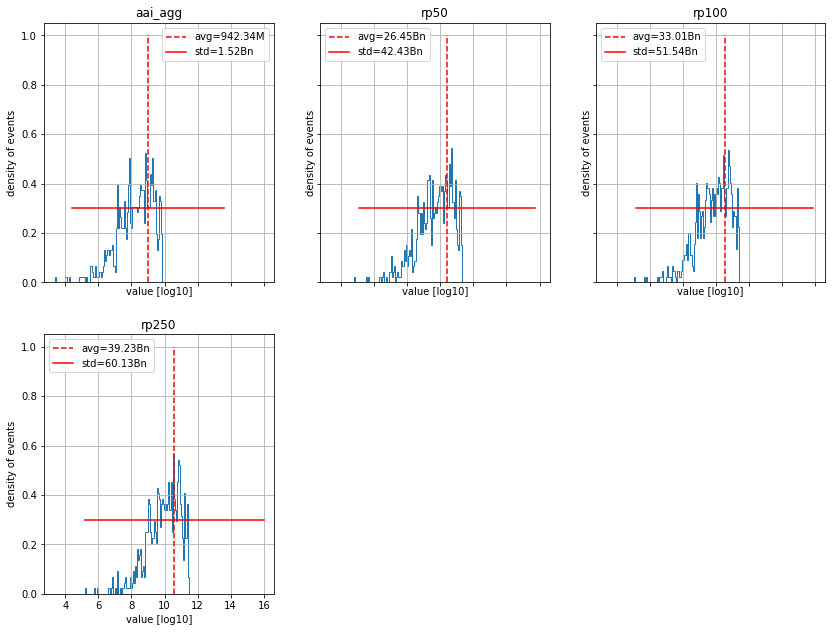

In [9]:
unc.plot_distribution(metric_list=['aai_agg', 'freq_curve']);

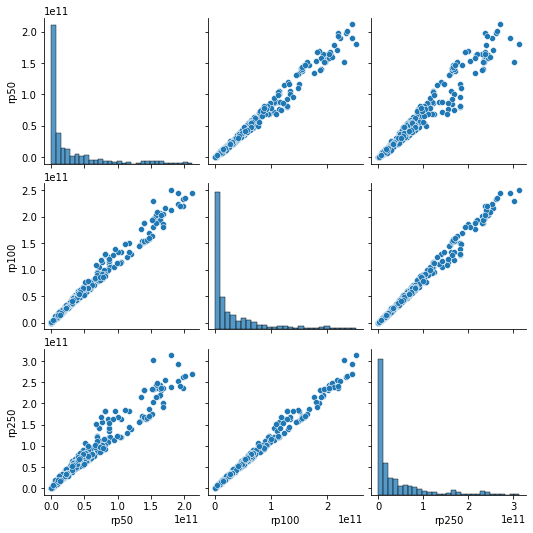

In [10]:
freq_curve = unc.metrics['freq_curve']
sns.pairplot(freq_curve);

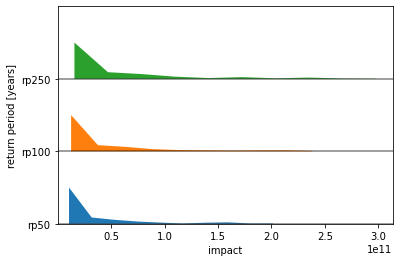

In [11]:
unc.plot_rp_distribution();

In [12]:
unc.calc_sensitivity(salib_method='sobol', method_kwargs = {'conf_level' : 0.95, 
                                                           'calc_second_order': False})

{'aai_agg': {'aai_agg': {'S1': array([0.35318387, 0.02888573, 0.29028966, 0.00244575, 0.07365607]),
   'S1_conf': array([0.17446411, 0.03868715, 0.20485541, 0.02042561, 0.1139039 ]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.20575982, 0.01511433, 0.30697754, 0.00775368, 0.12153214])}},
 'freq_curve': {'rp50': {'S1': array([0.35762565, 0.02671238, 0.30429953, 0.00039749, 0.07185341]),
   'S1_conf': array([0.16363413, 0.03739326, 0.18663866, 0.01883942, 0.11373711]),
   'ST': array([0.4598212 , 0.02464501, 0.61748473, 0.01009205, 0.23096831]),
   'ST_conf': array([0.23389444, 0.01565841, 0.28418247, 0.00768911, 0.13679538])},
  'rp100': {'S1': array([3.68793718e-01, 2.63885339e-02, 3.39009260e-01, 2.81072504e-04,
          5.76714553e-02]),
   'S1_conf': array([0.16427824, 0.04050283, 0.27599983, 0.01750724, 0.12748675]),
   'ST': array([0.4745089 , 0.02347709, 0.71585254, 0.0063869 , 0.16279755]),
   'ST_conf': array([0.18368028

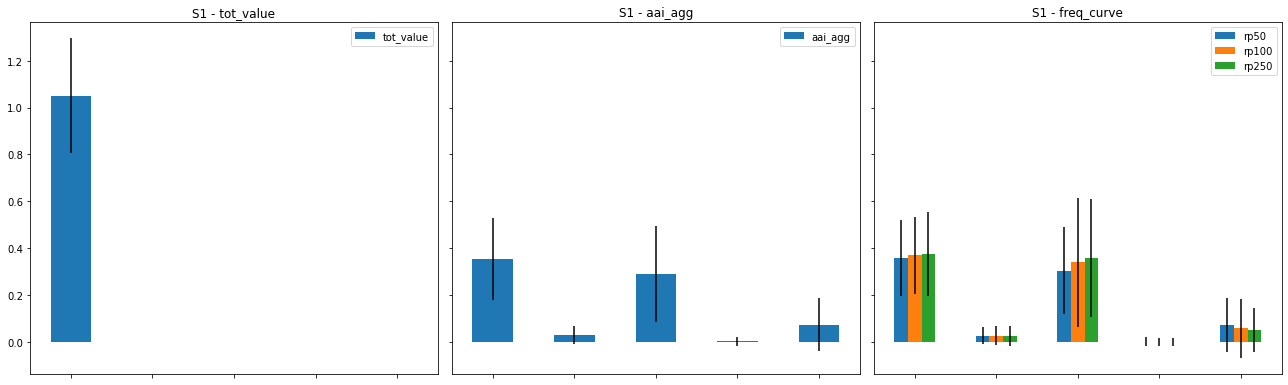

In [13]:
unc.plot_sensitivity();

### Different Salib method 

In [14]:
unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=100, sampling_method='latin')

2021-03-04 17:31:49,834 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 100


,x_exp,G,v_half,vmin,k
0,0.504802,0.901129,76.467354,3.588861,3.771724
1,0.349540,1.187541,85.440659,2.424383,5.291858
2,0.570447,0.823728,75.099160,6.552266,2.564862
3,0.805580,1.107778,68.410706,1.943593,1.907262
4,0.152053,0.953482,122.387959,5.910890,5.771246
...,...,...,...,...,...
95,0.300733,0.836096,63.962457,3.094283,4.143099
96,0.053260,1.009185,59.836034,2.311935,5.995622
97,0.535094,0.827938,128.243932,7.476707,3.525856
98,0.741995,0.815751,78.659363,11.056927,5.214039


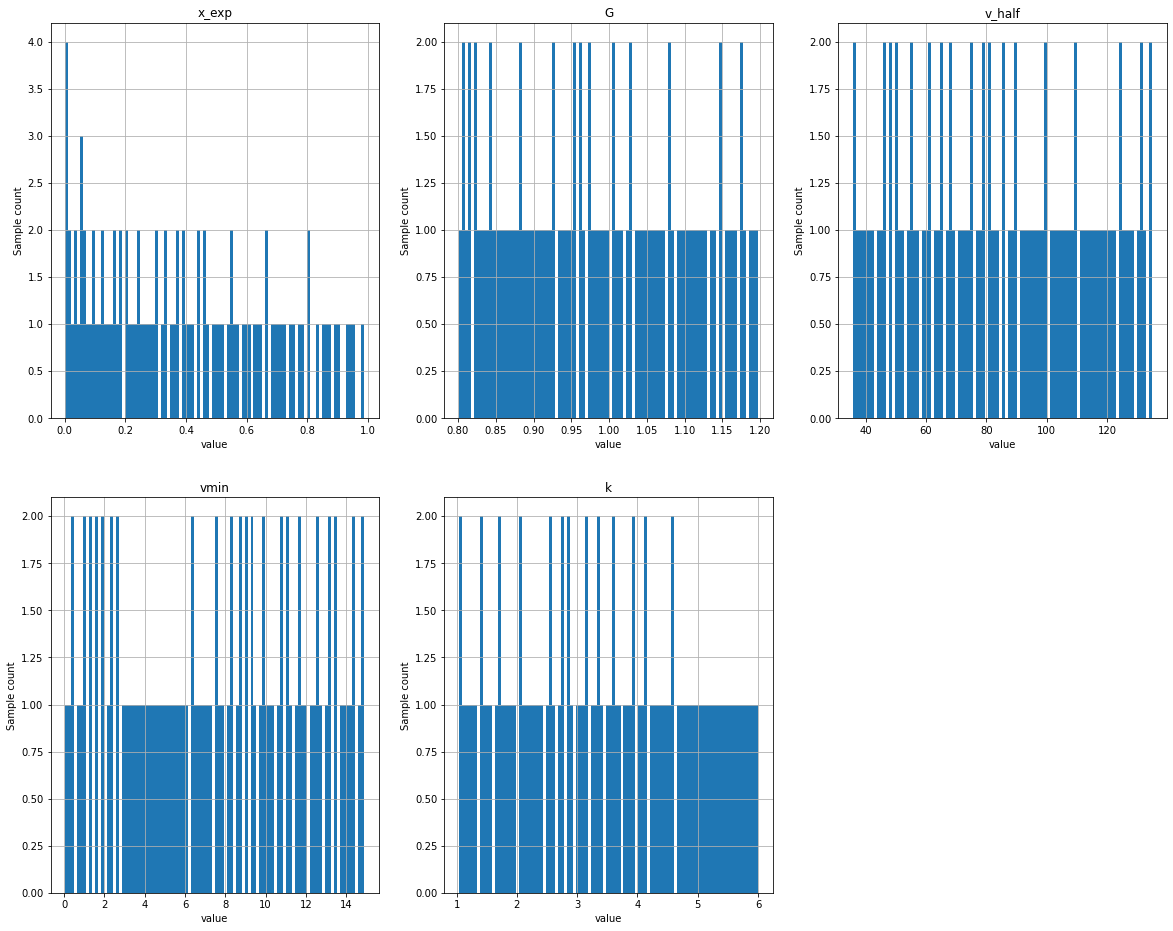

In [15]:
unc.plot_sample();

In [16]:
unc.calc_distribution(rp = [50, 100, 250], )

2021-03-04 17:31:51,095 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 17:31:51,097 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-04 17:31:51,098 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:31:51,104 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:31:51,108 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 1.5699999999999998s



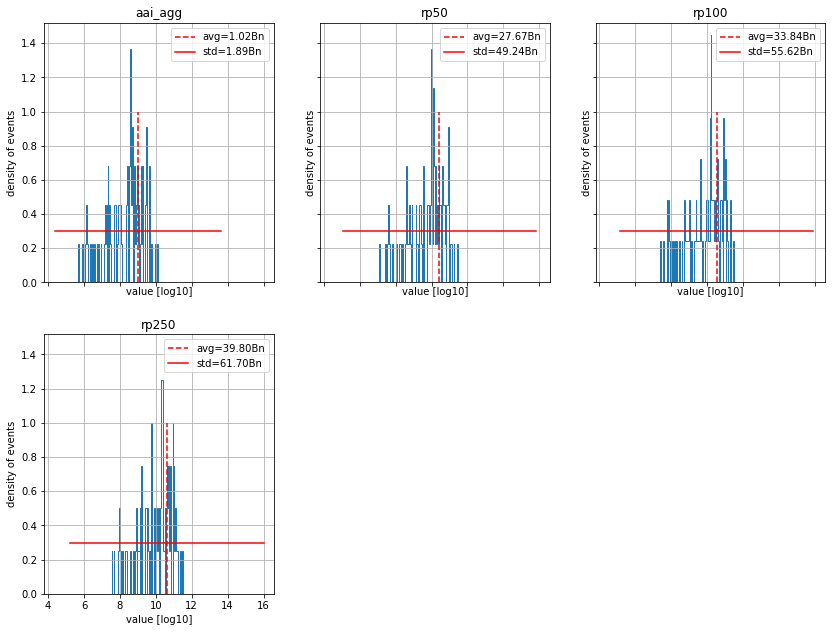

In [17]:
unc.plot_distribution(metric_list=['aai_agg', 'freq_curve']);

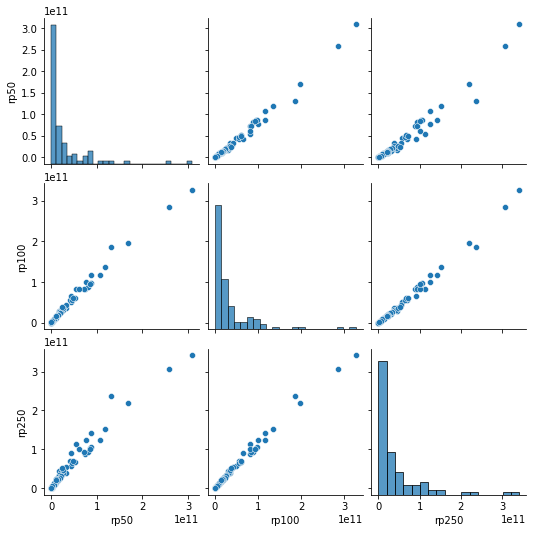

In [18]:
freq_curve = unc.metrics['freq_curve']
sns.pairplot(freq_curve);

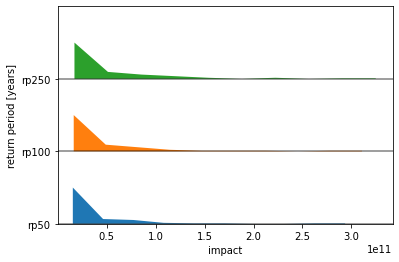

In [19]:
unc.plot_rp_distribution();

In [20]:
unc.calc_sensitivity(salib_method='rbd_fast', method_kwargs = {'M': 15})

{'aai_agg': {'aai_agg': {'S1': [0.08359302397987489,
    0.02328296748343589,
    0.20672797876890212,
    -0.04043753817967949,
    0.2927827203818488],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'freq_curve': {'rp50': {'S1': [0.09456209408899946,
    0.03539876428326316,
    0.2299227890267549,
    -0.033953395645216766,
    0.28956614144848963],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp100': {'S1': [0.1237566884216239,
    0.05474750972389236,
    0.26656954766206337,
    -0.017939185771831012,
    0.26848925275856],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp250': {'S1': [0.1482259622954878,
    0.06954047028904897,
    0.2907247660183472,
    -0.0014991845749909305,
    0.25099342046035056],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'eai_exp': {},
 'at_event': {},
 'tot_value': {'tot_value': {'S1': [0.9996942321914176,
    0.011188495124674624,
    0.01482792936734012,
    0.009382692424057981,
    0.091347904517316],
   'names'

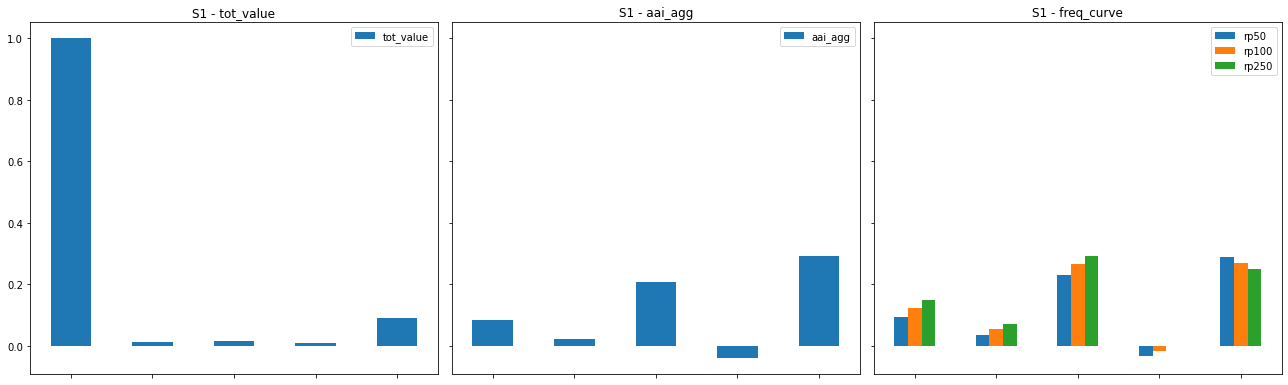

In [21]:
unc.plot_sensitivity();

## Cost Benefit 

In [4]:
def ent_today(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.value *= x_ent
    entity.check()
    return entity

def ent_future():
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040
    entity.check()
    return entity

def haz_fut_func(x_haz_fut, haz_base=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


In [5]:
haz = haz_base

haz_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_distr)

ent_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_unc = UncVar(ent_today, ent_distr)

ent_fut = ent_future()

2021-03-04 17:33:35,054 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-03-04 17:33:35,054 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-03-04 17:33:35,055 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-03-04 17:33:35,055 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 17:33:35,056 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-04 17:33:35,056 - climada.entity.exposures.base - INFO - region_id not set.
2021-03-04 17:33:35,057 - climada.entity.exposures.base - INFO - geometry not set.


In [6]:
unc = UncCostBenefit(haz_unc=haz, ent_unc=ent_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut)
unc.make_sample(N=10)
unc.sample.head()

2021-03-04 17:33:36,239 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 60


,x_ent,x_haz_fut
0,0.919727,1.290039
1,1.218555,1.290039
2,0.919727,3.030273
3,0.919727,3.030273
4,1.218555,1.290039


In [7]:
pool = Pool()
unc.calc_distribution(pool=pool)
pool.close()
pool.join()
pool.clear()

2021-03-04 17:33:37,493 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-03-04 17:33:37,495 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-03-04 17:33:37,496 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-03-04 17:33:37,497 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 17:33:37,498 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-04 17:33:37,498 - climada.entity.exposures.base - INFO - region_id not set.
2021-03-04 17:33:37,499 - climada.entity.exposures.base - INFO - geometry not set.
2021-03-04 17:33:37,503 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:37,523 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:37,530 - climada.engine.impact - INFO - Exposures matching centroids found in centr

2021-03-04 17:33:37,933 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:37,937 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:37,938 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:37,937 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-03-04 17:33:37,941 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:37,943 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-03-04 17:33:37,945 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:37,949 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:37,948 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-03-04 


2021-03-04 17:33:38,085 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,085 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,089 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,089 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,088 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-03-04 17:33:38,092 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-03-04 17:33:38,096 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-03-04 17:33:38,097 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,099 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03

2021-03-04 17:33:38,205 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,200 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


2021-03-04 17:33:38,210 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,209 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,210 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
--------------------  -------  --------
Total climate risk:   159.794  (USD bn)
Average annual risk:   18.514  (USD bn)
Residual risk:        103.729  (USD bn)
--------------------  -------  --------2021-03-04 17:33:38,212 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-04 17:33:38,206 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,217 - climada.engine.impact -

2021-03-04 17:33:38,326 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,330 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,329 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,329 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,339 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:38,342 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177           10.131          7.72319
Beach nourishment          1.728              7.99277        4.62545
Seawall                    8.87878            0.424078       0.0477

2021-03-04 17:33:38,609 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:38,610 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,610 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,614 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,616 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,618 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,618 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,618 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,618 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,621 -

2021-03-04 17:33:38,714 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-03-04 17:33:38,716 - climada.entity.exposures.base - INFO - region_id not set.
2021-03-04 17:33:38,718 - climada.entity.exposures.base - INFO - geometry not set.
2021-03-04 17:33:38,718 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 17:33:38,721 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-04 17:33:38,722 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:38,724 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-03-04 17:33:38,725 - climada.entity.exposures.base - INFO - region_id not set.
2021-03-04 17:33:38,726 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-04 17:33:38,727 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-03-04 17:33:38,72

2021-03-04 17:33:38,805 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,807 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,810 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,810 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:38,811 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:38,811 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,813 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,815 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,815 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:38,816 - cli

Building code              9.2              4.48068         0.4870312021-03-04 17:33:39,012 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-04 17:33:39,013 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-04 17:33:39,017 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
--------------------  --------  --------
Total climate risk:   17.9227   (USD bn)
Average annual risk:   2.02123  (USD bn)
Residual risk:         2.07937  (USD bn)
--------------------  --------  --------2021-03-04 17:33:39,019 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-04 17:33:39,021 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Net Present Values2021-03-04 17:33:39,024 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.

2021-03-04 17:33:39,028 - climada.engine.cost_benefit 

2021-03-04 17:33:39,196 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,197 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,198 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,200 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,204 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,206 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,220 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,223 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,230 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
202

Building code              9.2                45.0948         4.90161

2021-03-04 17:33:39,337 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-03-04 17:33:39,340 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 17:33:39,331 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-04 17:33:39,344 - climada.entity.exposures.base - INFO - category_id not set.

--------------------  --------  --------
Total climate risk:   180.379   (USD bn)
Average annual risk:   20.8872  (USD bn)
Residual risk:        119.857   (USD bn)
--------------------  --------  --------2021-03-04 17:33:39,347 - climada.entity.exposures.base - INFO - region_id not set.

2021-03-04 17:33:39,351 - climada.entity.exposures.base - INFO - geometry not set.
Net Present Values2021-03-04 17:33:39,356 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.

2021-03-04 17:33:39,363 - climada.engine.imp

2021-03-04 17:33:39,488 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,489 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,492 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,494 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,495 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,495 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,497 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,498 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,498 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,50

2021-03-04 17:33:39,615 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:39,611 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-03-04 17:33:39,619 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:39,618 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD

2021-03-04 17:33:39,620 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177           13.7592        10.4891
Beach nourishment          1.728             10.7213         6.20443
Seawall                    8.87878            0.179075       0.0201689
Building code              9.2               29.6118    

2021-03-04 17:33:39,752 - climada.entity.exposures.base - INFO - region_id not set.
2021-03-04 17:33:39,755 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,755 - climada.entity.exposures.base - INFO - geometry not set.
2021-03-04 17:33:39,758 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,758 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,760 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:39,762 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,763 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,765 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,768 - climada.engine.impact - INFO - Calculating damage for 

2021-03-04 17:33:39,889 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177             7.27915        5.54911
Beach nourishment          1.728               5.68031        3.28722
Seawall                    8.87878             2.89836        0.326437
Building code              9.2                47.1234         5.122112021-03-04 17:33:39,895 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:39,897 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-04 17:33:39,900 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:39,901 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

--------------------  --------  ---

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177           13.7592        10.4891
Beach nourishment          1.728             10.7213         6.20443
Seawall                    8.87878            0.179075       0.0201689
Building code              9.2               29.6118         3.218672021-03-04 17:33:40,058 - climada.entity.exposures.base - INFO - region_id not set.
2021-03-04 17:33:40,062 - climada.entity.exposures.base - INFO - geometry not set.

2021-03-04 17:33:40,063 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-04 17:33:40,066 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:40,067 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:40,068 - climada.entity.exposures.base - INFO - Matching 50 exposures with 25


2021-03-04 17:33:40,251 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177             6.62297        5.04889
Beach nourishment          1.728               5.20803        3.01391
Seawall                    8.87878             3.60281        0.405778
Building code              9.2                48.0945         5.227662021-03-04 17:33:40,254 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD


--------------------  -------  --------
Total climate risk:   192.378  (USD bn)
Average annual risk:   22.268  (USD bn)
Residual risk:        128.85   (USD bn)
--------------------  -------  --------2021-03-04 17:33:40,258 - climada.entity.exposures.base - INFO - meta metadata set to default value: None

2021-03-04 17:33:40,261 - cl

2021-03-04 17:33:40,416 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:40,421 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:40,422 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:40,424 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:40,425 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:40,428 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:40,429 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:40,428 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:40,432 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:40,433 - climad

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177          10.7463         8.19224
Beach nourishment          1.728             8.75119        5.06435
Seawall                    8.87878           0.0192535      0.00216849
Building code              9.2               7.73749        0.8410312021-03-04 17:33:40,556 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:40,559 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-04 17:33:40,561 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 17:33:40,561 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:40,562 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}

2021-03-04 17:33:40,566 - climada.engine.cos

2021-03-04 17:33:40,687 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:40,688 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:40,688 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:40,690 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:40,695 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-04 17:33:40,698 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177          10.6685         8.13292
Beach nourishment          1.728             8.68766        5.02758
Seawall                    8.87878           0.0192535      0.0021684

2021-03-04 17:33:40,854 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2021-03-04 17:33:40,855 - climada.entity.exposures.base - INFO - geometry not set.
Net Present Values2021-03-04 17:33:40,857 - climada.entity.exposures.base - INFO - centr_ not set.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177            8.5647          6.52913
Beach nourishment          1.728              6.52475         3.7759
Seawall                    8.87878            0.913258        0.102859
Building code              9.2               41.5968          4.52142021-03-04 17:33:40,860 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.

2021-03-04 17:33:40,862 - climada.entity.exposures.base - INFO - category_id not set.

2021-03-04 17:33:40,866 - climada.entity.exposures.base - INFO - region_id not set.

2021-03-04 

2021-03-04 17:33:41,019 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:41,023 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:41,024 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:41,024 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:41,028 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:41,029 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:41,028 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:41,031 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:41,035 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:41,038 - cli

2021-03-04 17:33:41,186 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-04 17:33:41,188 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Net Present Values
2021-03-04 17:33:41,196 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:41,197 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:41,200 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:41,203 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:41,201 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-03-04 17:33:41,211 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2021-03-04 17:33:41,208 - climada.engine.impact - INFO - Exposures matching centroids f

Building code              9.2             0.979438        0.1064612021-03-04 17:33:41,383 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-04 17:33:41,383 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:41,386 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

--------------------  ---------  --------
Total climate risk:    3.91775   (USD bn)
Average annual risk:   0.35763   (USD bn)
Residual risk:        -0.167382  (USD bn)
--------------------  ---------  --------2021-03-04 17:33:41,393 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:41,392 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

Net Present Values2021-03-04 17:33:41,397 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:41,398 - climada.engine.impact - INFO - C

2021-03-04 17:33:42,122 - climada.entity.exposures.base - INFO - geometry not set.
2021-03-04 17:33:42,123 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-04 17:33:42,126 - climada.entity.exposures.base - INFO - category_id not set.
2021-03-04 17:33:42,129 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:42,129 - climada.entity.exposures.base - INFO - region_id not set.
2021-03-04 17:33:42,135 - climada.entity.exposures.base - INFO - geometry not set.
2021-03-04 17:33:42,139 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,143 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:42,148 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,153 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,154 - climada.engine.

2021-03-04 17:33:42,304 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,309 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,309 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,310 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,313 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:42,318 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:42,319 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC

2021-03-04 17:33:42,323 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,324 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

Measure      

2021-03-04 17:33:42,457 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,458 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,464 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,464 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,469 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,469 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,472 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,474 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,479 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,482 - cli

2021-03-04 17:33:42,691 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-04 17:33:42,696 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,701 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,703 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,710 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,708 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,716 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,718 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,727 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,727 - climad

2021-03-04 17:33:42,888 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,888 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:42,890 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:42,893 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:42,897 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC


2021-03-04 17:33:42,902 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:42,904 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177           7.16911        5.46522
Beach nourishment        

2021-03-04 17:33:43,049 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:43,052 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:43,052 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:43,053 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:43,061 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-03-04 17:33:43,062 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2040.
2021-03-04 17:33:43,062 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-04 17:33:43,066 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.

2021-03-04 17:33:43,071 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
Measure              Cost (U

In [8]:
macro_metrics = list(unc.metrics.keys())
macro_metrics

['tot_climate_risk',
 'benefit',
 'cost_ben_ratio',
 'imp_meas_present',
 'imp_meas_future']

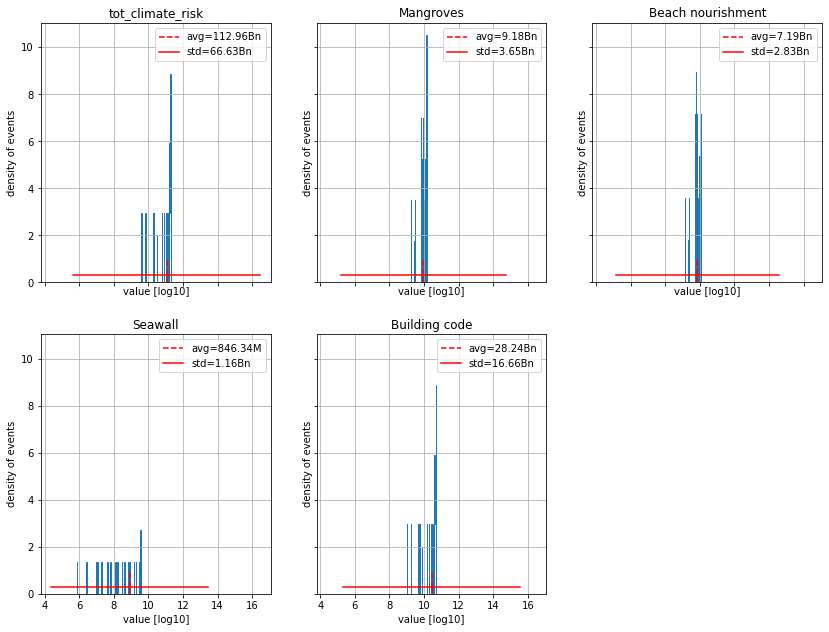

In [9]:
unc.plot_distribution(metric_list=['tot_climate_risk', 'benefit']);

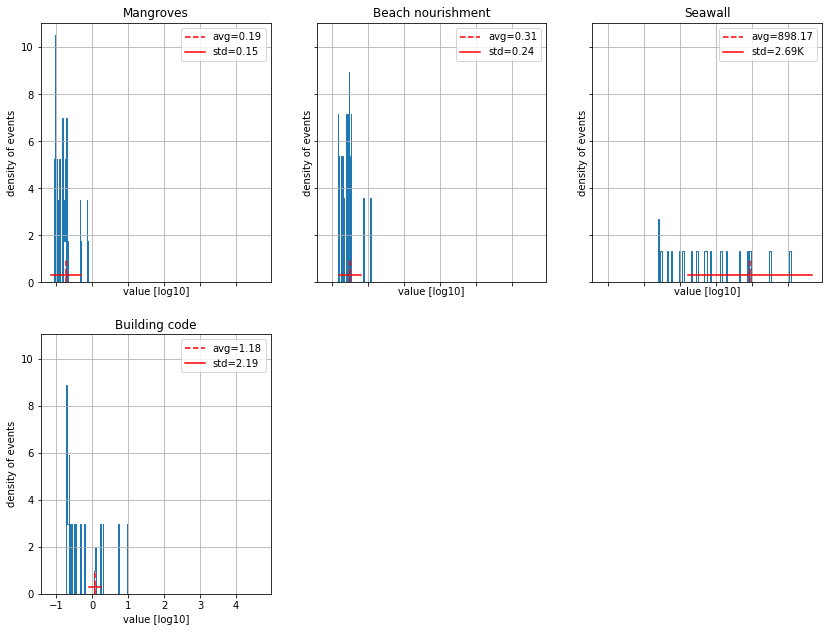

In [10]:
unc.plot_distribution(metric_list=['cost_ben_ratio'], );

In [11]:
unc.calc_sensitivity()

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib

{'tot_climate_risk': {'tot_climate_risk': {'S1': array([0.0018922 , 0.80416505]),
   'S1_conf': array([0.00265914, 0.64131804]),
   'ST': array([9.70209053e-06, 8.34154299e-01]),
   'ST_conf': array([1.16896095e-05, 6.03663857e-01]),
   'S2': array([[        nan, -0.00376499],
          [        nan,         nan]]),
   'S2_conf': array([[       nan, 0.00530643],
          [       nan,        nan]])}},
 'benefit': {'Mangroves': {'S1': array([0.01246896, 1.33346589]),
   'S1_conf': array([0.02353948, 0.85228642]),
   'ST': array([7.98637483e-04, 1.15435338e+00]),
   'ST_conf': array([0.00104058, 0.39138887]),
   'S2': array([[        nan, -0.02334064],
          [        nan,         nan]]),
   'S2_conf': array([[   nan, 0.0454],
          [   nan,    nan]])},
  'Beach nourishment': {'S1': array([0.01232256, 1.35383812]),
   'S1_conf': array([0.02542107, 0.81949236]),
   'ST': array([8.83987380e-04, 1.20059475e+00]),
   'ST_conf': array([0.00156844, 0.34768763]),
   'S2': array([[       

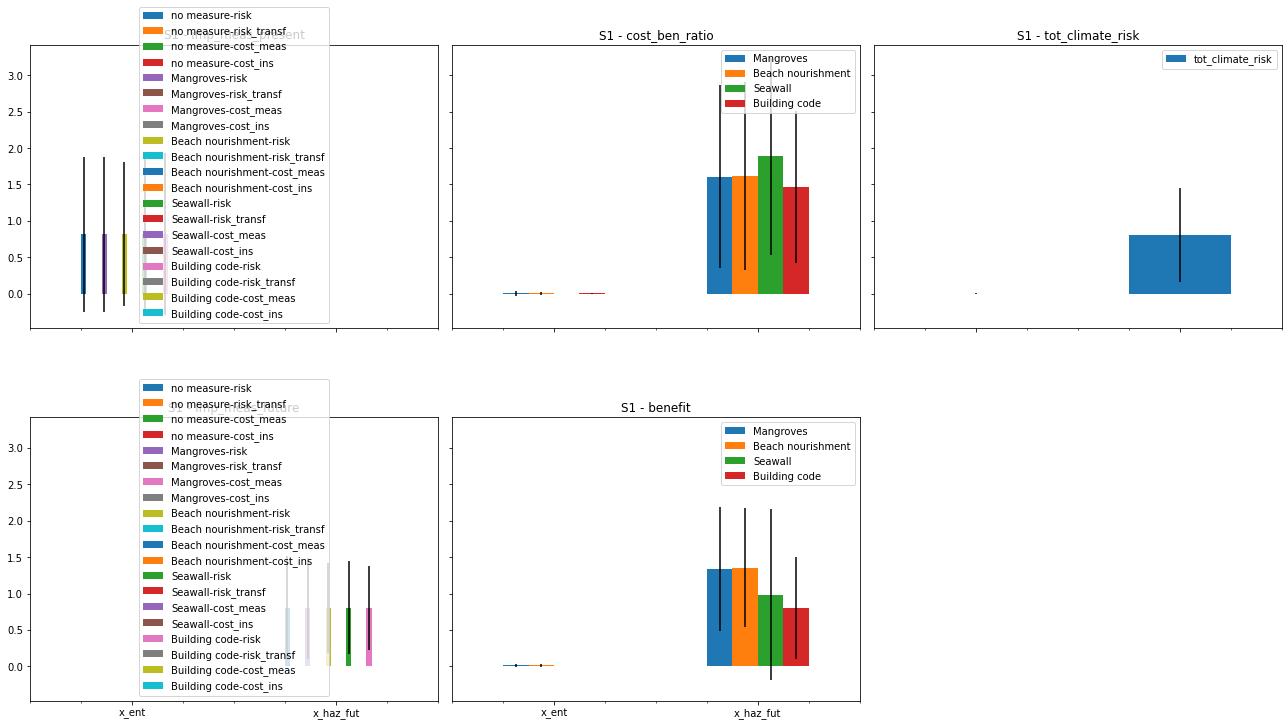

In [13]:
unc.plot_sensitivity();